# Locally Linear Embedding (40 P)

In this assignment we will look at locally linear embedding and experiment with it on artificially generated datasets. The effects of neighbourhood size and noise on result quality will be analyzed.

Information about the algorithm, publications and demos can be found at http://www.cs.nyu.edu/~roweis/lle/

A guide for plotting can be found here: http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-4-Matplotlib.ipynb

We first start by importing some basic python libraries for numerical computation and plotting.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import scipy.spatial, scipy.linalg

The file `utils.py` contains several methods to generate pseudo-random three-dimensional datasets. They all have a low-dimensional manifold structure. The following code plots each dataset with default generation parameters (`N=1000` examples, and Gaussian noise of scale `0.25`).

spiral


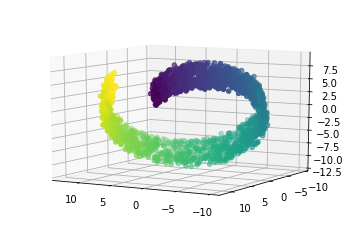

roll


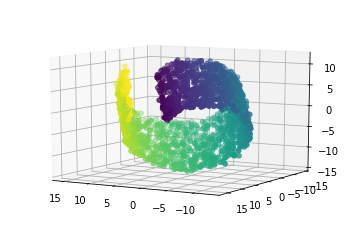

wave


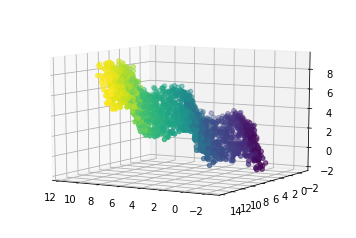

fold


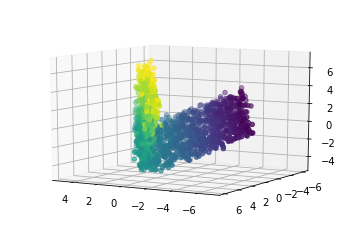

In [6]:
import utils
%matplotlib inline

for dataset in [utils.spiral,utils.roll,utils.wave,utils.fold]:
    print(dataset.__name__)
    data,color = dataset(N=2000,noise=0.25)
    plt.figure()
    ax = plt.gca(projection='3d')
    ax.view_init(elev=10., azim=120)
    ax.scatter(data[:,0],data[:,1],data[:,2],c=color.ravel())
    plt.show()

## Implementing LLE (20 P)

**Implement a function `LLE(data,k)`**. The function takes as input the high-dimensinonal data the number of neighbors `k` used for reconstruction in the LLE algorithm. It returns the resulting 2D embedding (a two-dimensional array of size `Nx2`). A backbone of the implementation is given below. The implementation of LLE is described in the paper "An Introduction to LLE" linked from ISIS.

*Reminder: During computation, you need to solve the problem Cw=**1**, where **1** is a column vector (1,1,...,1). In case k>d i.e. the size of the neighbourhood is larger than the number of dimensions of the space we're mapping to, it is necessary to regularize the matrix C. You can do this by adding positive terms on the diagonal. A good starting point is 0.05.*

In [296]:
# Backbone implementation
from sklearn import manifold
from sklearn.neighbors import NearestNeighbors

def LLE(data,k):
    N = len(data)
    W = np.zeros([N,N]) # matrix for storing reconstruction weights
    M = np.zeros([N,N]) # matrix M of which eigenvectors are computed
    E = np.zeros([N,2]) # eigenvectors of M forming the embedding

    m_estimate = []
    var_total = 0.0
    
    for row in range(N):
        #-----------------------------------------------
        #  find k nearest neighbors
        #-----------------------------------------------d,N = M.shape
        
        M_Mi = np.array(data - data[row,:])
        vec = (M_Mi**2).sum(0)
        nbrs = np.argsort(vec)[1:k+1]
        #print (nbrs)

        M_Mi = np.asmatrix(M_Mi[:,nbrs])
        Q = M_Mi.T * M_Mi

        sig2 = (np.linalg.svd(M_Mi,compute_uv=0))**2

        # desired variance
        v=0.05
        sig2 /= sig2.sum()
        S = sig2.cumsum()
        m_est = S.searchsorted(v)
        if m_est>0:
            m_est += ( (v-S[m_est-1])/sig2[m_est] )
        else:
            m_est = v/sig2[m_est]
        m_estimate.append(m_est)
        
        r = np.sum(sig2[2:])
        var_total += r
        Q += r*np.identity(Q.shape[0])
    
        #solve for weight
        w = np.linalg.solve(Q,np.ones((Q.shape[0],1)))[:,0]
        w /= np.sum(w)

        #update row of the weight matrix
        W[row,nbrs] = w
        
    I = np.identity(W.shape[0])
    U,sig,VT = np.linalg.svd(W-I,full_matrices=0)
    indices = np.argsort(sig)[1:k]
    #return np.array(VT[:,indices])
    return manifold.locally_linear_embedding(data, n_neighbors=k, n_components=2)

### TODO: Replace with your own implementation of LLE
#import solutions
#from solutions import LLE
###
data,color = utils.roll()
LLE(data,3)

array([ array([[  8.60374908e-08,   5.41227127e-05],
       [  4.25366867e-07,   4.45792745e-04],
       [  1.71857708e-07,  -2.64362025e-04],
       ..., 
       [ -4.33386351e-05,   5.73122822e-04],
       [  3.91502887e-08,   5.74552128e-05],
       [ -8.38536873e-07,   9.86677670e-05]]),
       3.3436801158271878e-18], dtype=object)

**Test your implementation by running the code below.** It plots the original data (projected on the first two dimensions), and next to it, the two-dimensional embedding. A correct implementation produces a two-dimensional dataset where the manifold is unfolded, and where nearby points in the embedding are also neighbors in the manifold, in particular, neighboring points in the plot should have similar color.

IndexError: too many indices for array

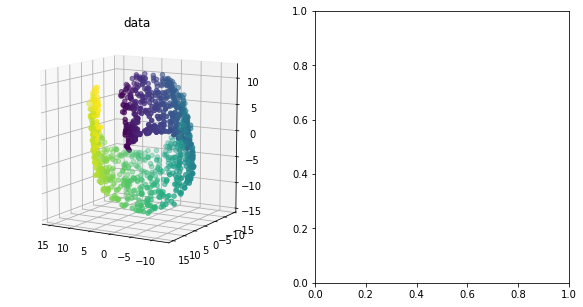

In [297]:
import utils
%matplotlib inline
data,color = utils.roll()
embedding = LLE(data,k=20) 
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1,projection='3d')
ax.view_init(elev=10., azim=120)
ax.scatter(data[:,0],data[:,1],data[:,2],c=color.ravel())
ax.set_title('data')

ax = fig.add_subplot(1,2,2)
ax.scatter(embedding[:,0],embedding[:,1],c=color.ravel())
ax.set_title('LLE')

## Experiments (20 P)

The function `compare(embed,dataset)`takes as input an embedding function and a dataset and plots the resulting embeddings for various choices of the parameter `k`, in particular, `k=5,20,80`.

In [30]:
def compare(embed, dataset):
    cols = 4
    
    fig = plt.figure(figsize=(3*cols, 3))
    
    # Plot the data
    data, color = dataset()
    ax = fig.add_subplot(1, cols, 1,projection='3d')
    ax.view_init(elev=10., azim=120)
    ax.scatter(data[:,0],data[:,1],data[:,2],c=color.ravel())
    
    ax.set_title('data')
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_zticks([], [])

    # Plot embeddings with various parameters K
    for i, k in enumerate([5,20,80]):
        ax = fig.add_subplot(1, cols, 2+i)

        z = embed(data,k=k)

        ax.scatter(z[:,0], z[:,1], c=color.ravel())
        ax.set_title('LLE, k=%d'%k)
        ax.set_xticks([], [])
        ax.set_yticks([], [])
    plt.tight_layout()
    plt.show()

### Datasets and optimal parameter `k`

The code below tests the LLE embedding algorithm on each dataset: spiral, roll, wave, and fold. **Explain** what is a good parameter `k` of the LLE algorithm, and how this parameter relates to the various properties of the dataset.

**In LLE algorithm, one can safely say that there is no such thing as an optimal number of K to execute the algorithm. Generally, the optimal value of K can be determined based on the type of data given. For example, if the data provided is for the different type of faces, then the data of faces of the same type can be neighbors.Only, running the algorithm with different K for given dataset is the way to determine the optimal value of K.**

**In the dataset and algorithm given in the exercise shows that the optimal values of K could be proven to K=20 in approximation but that also depends upon the properties of the dataset.**

**For dataset types:**

**SPIRAL : k=20 is the best solution as this is segregating the type of neighbors along with maintaining the relationship between the different type of neighbors as well. At the same time, K=5 is distorting the originally related neighbors also creating some outliers and K-80 is not able to segregate the neighbors neatly.**

**ROLL : k=20 is the best solution as this is segregating the type of neighbors along with maintaining the relationship between the different type of neighbors as well.At the same time, K=5 is creating a linear projection but with outliers and K-80 is not able to segregate the neighbors neatly, there are overlappings.**

**WAVE : There is no much difference between K=20 and K=80, both the graphs look almost same and so dictating the optimal value of K here is a little troublesome. However, the performance of the algorithm could be efficient with less number of K so K=20 could be a good number for neighbors. At the same time, K=5 has a lot of overlaps and so it is a bad number of neighbors to run the algorithm.**

**FOLD : Almost same this is happening what happened with WAVE  type of data. K=20 and K=80 are almost generating the same type of linear embedding so, both could be counted as a good number of K. however, the performance of algorithm also matters, where efficiency decrease with more number of neighbors. At the same time, K=5 could be proven the bad number as there are overlapping as well as outliers present in the graph. **

spiral


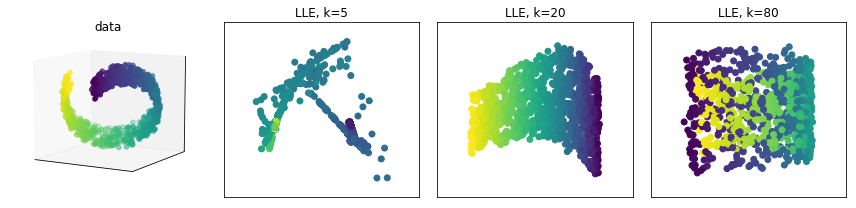

roll


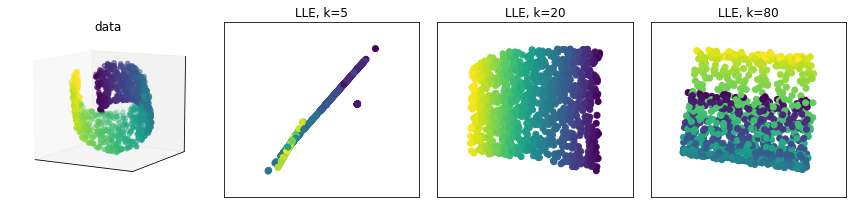

wave


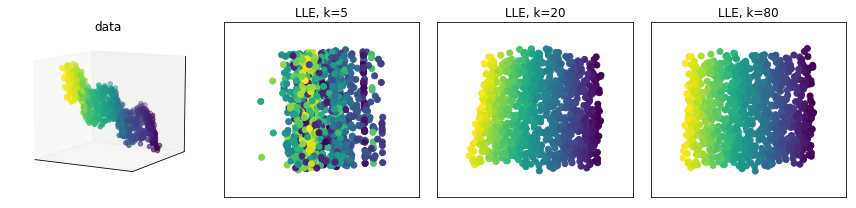

fold


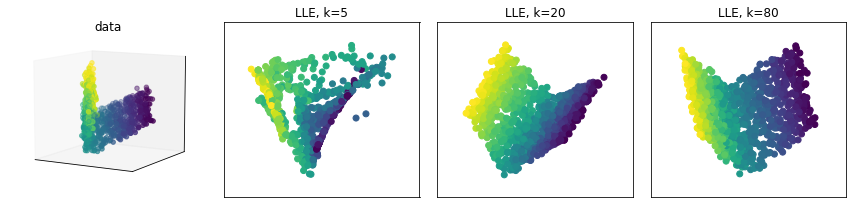

In [31]:
for dataset in [utils.spiral,utils.roll,utils.wave,utils.fold]:
    print(dataset.__name__)
    compare(LLE,dataset)

### LLE and the effect of noise

The code below tests LLE on the spiral dataset with three different levels of noise. **Describe** how the noise affects the embedding.

**
Weight vector in LLE is quite sensitive to the noise in the data which can be regularized to reduce the sensitiveness to noise by adding an eigen value.**

**As is clearly seen in the below graphs that with a higher amount of noise present in the data could also affect the optimal value of K to draw the linear embedding. 
With noise level : 0.100, the embedding looks good with k=20 however, Embedding with K=80 is overlapped.
With noise level : 0.300, the embedding with all K=5,20,80 is not able to preserve the structure of high dimension structures.
With noise level : 1.000, the embedding with K=20 and K=80 looks to be creating the local embedding quite OK but the direction of the embedding is affected.**

noise=0.100


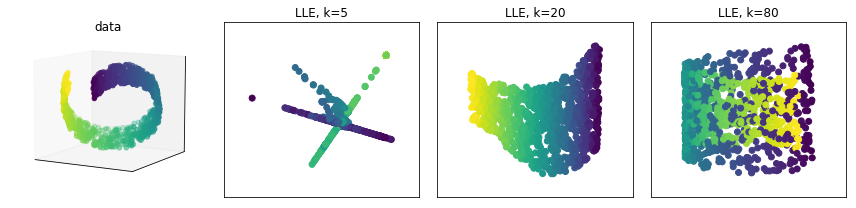

noise=0.300


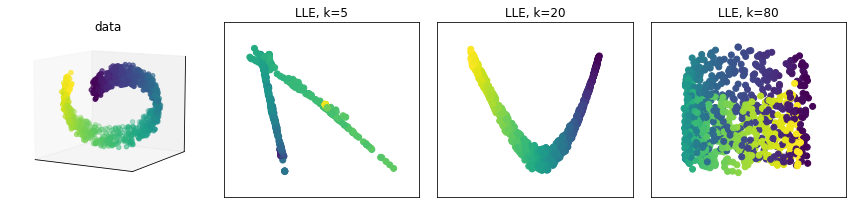

noise=1.000


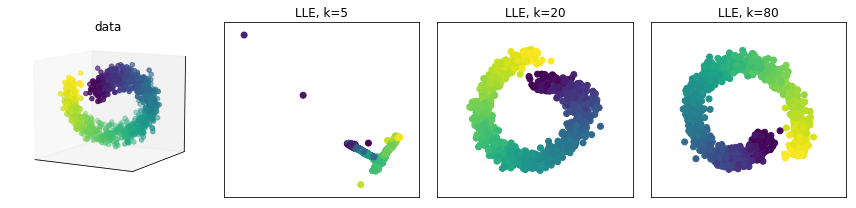

In [32]:
for noise in [0.1,0.3,1.0]:
    print('noise=%.3f'%noise)
    dataset = lambda: utils.spiral(noise=noise)
    compare(LLE,dataset)

### Discussion

* When applying LLE to a 200-dimensional dataset which can't be visualized, how would you assess whether the found embedding is good? Discuss how you would do it or argue why it can't be done.

**Human vision may be limited to few dimensions but we can visualize the data using mathematical formulas which enables us to visualize the data of even 200-dimensions. There are multiple mathematical computations in the form of algorithms are present to convert the high dimension data to lower dimension and we can prove their accuracy mathematically. For example, t-SNE performs this task by calculating the mapped distance and LLE performs with the error cost. **

* Could utilizing this technique in conjuction with a classifier improve its performance? Which classifiers, if any, would benefit the most?

**This particular LLE technique could perform well with classifiers but maybe not with very high dimensional data (D>6 or so). As at high dimension, LLE starts overfitting the data because of its nonlinear nature. However, for low dimensions, automatic regularisation is a pretty effective classifier to train the data with.**
 